In [ ]:
using Catalyst, DifferentialEquations, Plots, Latexify, StructuralIdentifiability, ModelingToolkit, Sundials

In [ ]:

# rn = @reaction_network begin
#   (k1_f, k1_r), OF <--> IF
#   (k2_f, k2_r), OF + H_out <--> OF_Hb
#   (k3_f, k3_r), OF_Sb <--> OF + S_out
#   (k4_f, k4_r), OF_Hb <--> IF_Hb
#   (k5_f, k5_r), OF_Hb_Sb <--> OF_Hb + S_out
#   (k6_f, k6_r), IF_Sb <--> OF_Sb
#   (k7_f, k7_r), OF_Sb + H_out <--> OF_Hb_Sb
#   (k8_f, k8_r), OF_Hb_Sb <--> IF_Hb_Sb
#   (k9_f, k9_r), IF_Hb <--> IF + H_in
#   (k10_f, k10_r), IF + S_in <--> IF_Sb
#   (k11_f, k11_r), IF_Hb + S_in <--> IF_Hb_Sb
#   (k12_f, k12_r), IF_Hb_Sb <--> IF_Sb + H_in    
# end k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r k7_f k7_r k8_f k8_r k9_f k9_r k10_f k10_r k11_f k11_r k12_f k12_r
# odesys = convert(ODESystem, rn)

function calc_flux(conc_terms, rate_terms, vol)
    IF_Hb_Sb = conc_terms[1]
    IF_Sb = conc_terms[2]
    H_in = conc_terms[3]
    rxn12_k1 = rate_terms[1]
    rxn12_k2 = rate_terms[2]
    x1 = rxn12_k1*IF_Hb_Sb
    x2 = rxn12_k2*IF_Sb.*H_in
    y_pred = vol*(x1-x2)  # returns y_pred            
end


rn2 = @reaction_network begin
  (k1_f, k1_r), OF <--> IF
  (k2_f*H_out, k2_r), OF <--> OF_Hb
  (k3_f, k3_r*S_out), OF_Sb <--> OF
  (k4_f, k4_r), OF_Hb <--> IF_Hb
  (k5_f, k5_r*S_out), OF_Hb_Sb <--> OF_Hb 
  (k6_f, k6_r), IF_Sb <--> OF_Sb
  (k7_f*H_out, k7_r), OF_Sb <--> OF_Hb_Sb
  (k8_f, k8_r), OF_Hb_Sb <--> IF_Hb_Sb
  (k9_f, k9_r), IF_Hb <--> IF + H_in
  (k10_f, k10_r), IF + S_in <--> IF_Sb
  (k11_f, k11_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k12_f, k12_r), IF_Hb_Sb <--> IF_Sb + H_in    
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r k7_f k7_r k8_f k8_r k9_f k9_r k10_f k10_r k11_f k11_r k12_f k12_r


odesys2 = convert(ODESystem, rn2)
equations(odesys2)

k_conf = 1e2
k_H_on = 1e10
k_H_off = 1e3
k_S_on = 1e7
k_S_off = 1e3

@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r k7_f k7_r k8_f k8_r k9_f k9_r k10_f k10_r k11_f k11_r k12_f k12_r
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) OF_Sb(t) OF_Hb_Sb(t) IF(t) IF_Hb(t) IF_Sb(t) IF_Hb_Sb(t)
pmap  = (H_out => 1e-7, S_out => 1e-3,
        k1_f =>0, k1_r =>0,
        k2_f =>k_H_on, k2_r =>k_H_off,
        k3_f =>k_S_off, k3_r =>k_S_on,
        k4_f =>k_conf, k4_r =>k_conf,
        k5_f =>0, k5_r =>0,
        k6_f =>k_conf, k6_r =>k_conf,
        k7_f =>0, k7_r =>0,
        k8_f =>0, k8_r =>0,
        k9_f =>0, k9_r =>0,
        k10_f =>0, k10_r =>0,
        k11_f =>k_S_on, k11_r =>k_S_off,
        k12_f =>k_H_off, k12_r =>k_H_on,
)

u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, IF => 2.125e-08, 
        OF_Hb => 2.833e-8, IF_Hb => 2.833e-8, 
        OF_Sb => 2.125e-08, IF_Sb => 2.125e-08, 
        OF_Hb_Sb => 2.125e-08, IF_Hb_Sb => 2.833e-8, 

]

tspan = (0.0,10.0)
oprob = ODEProblem(odesys2, u0map, tspan, pmap)
event_times = 5.0
condition(u,t,integrator) = t ∈ event_times
affect!(integrator) = integrator.p["H_in"] = 5e-8
cb = DiscreteCallback(condition,affect!)
#sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-16, abstol=1e-18, saveat=0.04,callback=cb, tstops=[5.0])
sol = solve(oprob, Rosenbrock23(), saveat=0.04,callback=cb, tstops=[5.0])


# event_times = [5.0,]
# condition(u,t,integrator) = t ∈ event_times
# affect!(integrator) = integrator.p[12] = 5e-8
# cb = DiscreteCallback(condition,affect!)
# sol = solve(oprob, CVODE_BDF(), saveat=0.04, abstol = 1e-16, reltol = 1e-18, callback=cb, tstops=[5.0])


# tspan = (0., 5)
# oprob = ODEProblem(odesys2, u₀map, tspan, pmap)
# sol = solve(oprob, CVODE_BDF(), reltol=1e-16, abstol=1e-18)

# calcualte flux 
# conc_terms = [sol[IF_Hb_Sb],sol[IF_Sb],sol[H_in]]
# rate_terms = [k_H_off,k_H_on]
# vol = 0.0001
# y_pred = calc_flux(conc_terms, rate_terms, vol)
# plot(y_pred)

In [ ]:
test_ode = @ODEmodel(
    OF'(t) = k1_r*IF(t)+k2_r*OF_Hb(t)+k3_f*OF_Sb(t)−k1_f*OF(t)−H_out*k2_f*OF(t)−S_out*k3_r*OF(t),
    IF'(t) = k9_f*IF_Hb(t)+k10_r*IF_Sb(t)+k1_f*OF(t)−k1_r*IF(t)−k9_r*H_in(t)*IF(t)−k10_f*IF(t)*S_in(t),
    OF_Hb'(t) = k4_r*IF_Hb(t)+k5_f*OF_Hb_Sb(t)+H_out*k2_f*OF(t)−k2_r*OF_Hb(t)−k4_f*OF_Hb(t)−S_out*k5_r*OF_Hb(t),
    OF_Sb'(t) = k6_f*IF_Sb(t)+k7_r*OF_Hb_Sb(t)+S_out*k3_r*OF(t)−k3_f*OF_Sb(t)−k6_r*OF_Sb(t)−H_out*k7_f*OF_Sb(t),
    IF_Hb'(t) = k11_r*IF_Hb_Sb(t)+k4_f*OF_Hb(t)−k4_r*IF_Hb(t)−k9_f*IF_Hb(t)+k9_r*H_in(t)*IF(t)−k11_f*IF_Hb(t)*S_in(t),
    OF_Hb_Sb'(t) = k8_r*IF_Hb_Sb(t)+S_out*k5_r*OF_Hb(t)−k5_f*OF_Hb_Sb(t)+H_out*k7_f*OF_Sb(t)−k7_r*OF_Hb_Sb(t)−k8_f*OF_Hb_Sb(t),
    IF_Sb'(t) = k12_f*IF_Hb_Sb(t)+k6_r*OF_Sb(t)−k10_r*IF_Sb(t)−k6_f*IF_Sb(t)+k10_f*IF(t)*S_in(t)−k12_r*H_in(t)*IF_Sb(t),
    IF_Hb_Sb'(t) = k8_f*OF_Hb_Sb(t)−k11_r*IF_Hb_Sb(t)−k12_f*IF_Hb_Sb(t)−k8_r*IF_Hb_Sb(t)+k12_r*H_in(t)*IF_Sb(t)+k11_f*IF_Hb(t)*S_in(t),
    H_in'(t) = k9_f*IF_Hb(t)+k12_f*IF_Hb_Sb(t)−k12_r*H_in(t)*IF_Sb(t)−k9_r*H_in(t)*IF(t),
    S_in'(t) = k10_r*IF_Sb(t)+k11_r*IF_Hb_Sb(t)−k10_f*IF(t)*S_in(t)−k11_f*IF_Hb(t)*S_in(t),
    y1(t) = H_out, 
    y2(t) = S_out, 
    y3(t) = H_in'(t)
)

@time global_id = assess_local_identifiability(test_ode,0.999, :SE)
println(global_id)



### Transporter reaction network

In [ ]:
using Catalyst, DifferentialEquations, StructuralIdentifiability, ModelingToolkit, Noise, Plots, DataFrames, CSV

# define reaction network
rn = @reaction_network begin
  (k1_f, k1_r), OF <--> IF
  (k2_f*H_out, k2_r), OF <--> OF_Hb
  (k3_f, k3_r*S_out), OF_Sb <--> OF
  (k4_f, k4_r), OF_Hb <--> IF_Hb
  (k5_f, k5_r*S_out), OF_Hb_Sb <--> OF_Hb 
  (k6_f, k6_r), IF_Sb <--> OF_Sb
  (k7_f*H_out, k7_r), OF_Sb <--> OF_Hb_Sb
  (k8_f, k8_r), OF_Hb_Sb <--> IF_Hb_Sb
  (k9_f, k9_r), IF_Hb <--> IF + H_in
  (k10_f, k10_r), IF + S_in <--> IF_Sb
  (k11_f, k11_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k12_f, k12_r), IF_Hb_Sb <--> IF_Sb + H_in    
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r k7_f k7_r k8_f k8_r k9_f k9_r k10_f k10_r k11_f k11_r k12_f k12_r

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)

# set reference values for parameters (rate constants and external H and S concentrations)
k_conf = 1e2
k_H_on = 1e10
k_H_off = 1e3
k_S_on = 1e7
k_S_off = 1e3
H_out_ref = 1e-7
S_out_ref = 1e-3

# set parameter/variable symbols and mapping
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r k7_f k7_r k8_f k8_r k9_f k9_r k10_f k10_r k11_f k11_r k12_f k12_r
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) OF_Sb(t) OF_Hb_Sb(t) IF(t) IF_Hb(t) IF_Sb(t) IF_Hb_Sb(t)
pmap  = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>0, k1_r =>0,
        k2_f =>k_H_on, k2_r =>k_H_off,
        k3_f =>k_S_off, k3_r =>k_S_on,
        k4_f =>k_conf, k4_r =>k_conf,
        k5_f =>0, k5_r =>0,
        k6_f =>k_conf, k6_r =>k_conf,
        k7_f =>0, k7_r =>0,
        k8_f =>0, k8_r =>0,
        k9_f =>0, k9_r =>0,
        k10_f =>0, k10_r =>0,
        k11_f =>k_S_on, k11_r =>k_S_off,
        k12_f =>k_H_off, k12_r =>k_H_on,
]

u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, IF => 2.125e-08, 
        OF_Hb => 2.833e-8, IF_Hb => 2.833e-8, 
        OF_Sb => 2.125e-08, IF_Sb => 2.125e-08, 
        OF_Hb_Sb => 2.125e-08, IF_Hb_Sb => 2.833e-8, 

]


# create ODEproblem 
tspan = (0.0,15.0)
oprob = ODEProblem(odesys, u0map, tspan, pmap)

#testing
probSS = SteadyStateProblem(rn,u0map, p=pmap )
sol = solve(prob,SSRootfind())

# # set timed events
# event_times = [5.0,10]
# condition(u,t,integrator) = t ∈ event_times
# function affect!(integrator)
#     if integrator.t == 5.0
#         integrator.p[1] = 5e-8
#     elseif integrator.t == 10.0
#         integrator.p[1] = 1e-7
#     end
# end
# #affect!(integrator) = integrator.p[:H_out] = 5e-8 
# cb = DiscreteCallback(condition,affect!)

# # solve ODE system
# sol = solve(oprob, TRBDF2(), abstol = 1e-14, reltol = 1e-6, saveat=0.04, callback=cb, tstops=[5.0, 10.0])

# # calculate flux
# function calc_ion_flux(p,u,v)
    
#     IF_Hb_Sb_tmp 
#     IF_Sb_tmp 
#     H_in_tmp 
#     rxn12_k1_tmp1
#     rxn12_k2_tmp1 

#     x11 = rxn12_k1_tmp1*IF_Hb_Sb_tmp1
#     x21 = rxn12_k2_tmp1*IF_Sb_tmp1.*H_in_tmp1

#     y_pred = vol_tmp1*(x11-x21)
    
#     k9_f = p[1]
#     k9_r = p[2]
    
#     flux_in = v*()
#     net_flux = flux_in - flux_out         
# end
# k = [pmap[19][2], pmap[20][2], pmap[25][2], pmap[26][2]]
# c = [sol[IF_Hb], sol[H_in], sol[IF], sol[IF_Hb_Sb], sol[IF_Sb]]
# vol = 0.0001
# y_true = calc_ion_flux(k,c,vol)

# # add noise to create synthetic flux trace
# stdev_ref = 1e-13
# y_obs = add_gauss(y_true,stdev_ref)
# #plot(y_true, legend = false, ylim=[-1.5e-11,1.5e-11]);scatter!(y_obs, alpha = 0.5)

# df = DataFrame(data = y_obs)
# CSV.write("data.csv", df)
# df2 = CSV.read("data.csv", DataFrame)
# y_obs2 = df2[!, "data"]
# scatter(y_obs, alpha = 0.5, ylim=[-1.5e-11,1.5e-11])

### Sampling

In [ ]:
using Turing

Turing.setadbackend(:forwarddiff)

@model function transporter_sampler(data, oprob)
    # set priors
    stdev_sample ~ Uniform(0.5e-13 , 1.25e-13) # ~ is the tilde character
    log_k2_f ~ Uniform(6, 12)  # H on rate (1e10)
    log_k2_r ~ Uniform(-1,5)  # H off rate (1e3)
    log_k3_f ~ Uniform(-1,5)  # S off rate (1e3)
    log_k3_r ~ Uniform(3,9)  # S on rate (1e7)
    log_k4_f ~ Uniform(-2,4)  # conf rate (1e2)
    log_k4_r ~ Uniform(-2,4)   # conf rate (1e2)
    log_k6_f ~ Uniform(-2,4)   # conf rate (1e2)
    log_k6_r ~ Uniform(-2,4)   # conf rate (1e2)
    log_k11_f ~ Uniform(3,9) # S on rate (1e7)
    log_k11_r ~ Uniform(-1,5)  # S off rate (1e3)
    log_k12_f ~ Uniform(-1,5)  # H off rate (1e3)
    log_k12_r = (log_k2_f+log_k3_f+log_k4_f+log_k6_f+log_k11_f+log_k12_f)-(log_k2_r+log_k3_r+log_k4_r+log_k6_r+log_k11_r)
     
    # set parameter values
    pmap1 = [H_out => H_out_ref, S_out => S_out_ref,
            k1_f =>0.0, k1_r =>0.0,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>0.0, k5_r =>0.0,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
            k7_f =>0.0, k7_r =>0.0,
            k8_f =>0.0, k8_r =>0.0,
            k9_f =>0.0, k9_r =>0.0,
            k10_f =>0.0, k10_r =>0.0,
            k11_f =>10.0^log_k11_f, k11_r =>10.0^log_k11_r,
            k12_f =>10.0^log_k12_f, k12_r =>10.0^log_k12_r,
    ]

    # create ODEproblem (same u0map and tspan as synthetic model)
    oprob1 = ODEProblem(odesys, u0map, tspan, pmap1)

    # set timed events
    event_times = [5.0,10]
    condition(u,t,integrator) = t ∈ event_times
    function affect!(integrator)
        if integrator.t == 5.0
            integrator.p[1] = 5e-8
        elseif integrator.t == 10.0
            integrator.p[1] = 1e-7
        end
    end
    cb = DiscreteCallback(condition,affect!)

    # solve ODE system
    sol1 = solve(oprob1, TRBDF2(), abstol = 1e-14, reltol = 1e-6, saveat=0.04, progress=false, callback=cb, tstops=[5.0, 10.0])

    # calc flux
    k1 = [pmap1[19][2], pmap1[20][2], pmap1[25][2], pmap1[26][2]]
    c1 = [sol1[IF_Hb], sol1[H_in], sol1[IF], sol1[IF_Hb_Sb], sol1[IF_Sb]]
    vol1 = 0.0001
    y_pred = calc_ion_flux(k1,c1,vol1)
    
    for i = 1:length(y_pred)
        data[i] ~ Normal(y_pred[i], stdev_sample)
    end
    
end

model = transporter_sampler(y_obs, oprob)

c = sample(model, NUTS(10000, .65),10000);

In [ ]:
c[:stdev_sample]

In [ ]:
c

In [ ]:
using StatsPlots
plot(c)

# 1:1 transporter - single cycle model

#### load and plot data

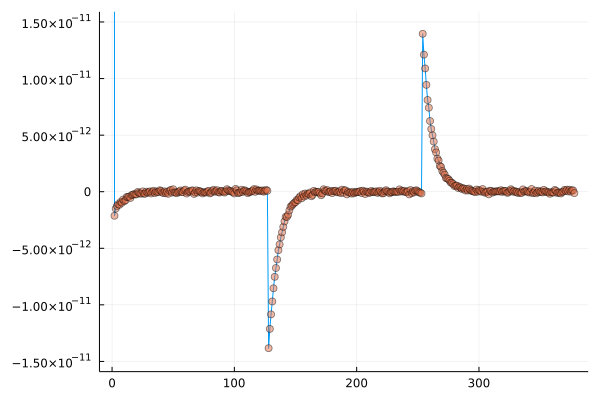

In [47]:
using Plots, DataFrames, CSV 

# load and plot data
df = CSV.read("data.csv", DataFrame)
y_obs = df[!, "data"]
plot(y_obs, legend = false, ylim=[-1.5e-11,1.5e-11]) ;scatter!(y_obs, legend = false, alpha = 0.5, ylim=[-1.5e-11,1.5e-11])

#### build catalyst model

In [57]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Turing, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
using Optim
Random.seed!(14)

# load flux dataset fo ~ 300 data points
df = CSV.read("data_1c.csv", DataFrame) 
y_obs = df[!, "data"]

# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out         
end

# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r stdev_s
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
H_out_ref = 1e-7
S_out_ref = 1e-3
pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)
latexify(odesys)


# create ODEproblem w/ timed events discrete callback
tspan1 = (0.0,15.0)
oprob = ODEProblem(odesys, u0map, tspan1, pmap)
event_times = [5.0,10]
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 5.0
        integrator.p[1] = 5e-8
    elseif integrator.t == 10.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,affect!)

### testing
# calc flux (y_pred)
sol1 = solve(oprob, TRBDF2(), abstol = 1e-19, reltol = 1e-17, saveat=0.04, callback=cb, tstops=[5.0, 10.0])
k1 = [pmap[9][2], pmap[10][2]]
c1 = [sol1[IF_Hb_Sb], sol1[H_in], sol1[IF_Sb]]
vol1 = 0.0001
y_pred = calc_flux(k1,c1,vol1)
df = DataFrame(data = y_pred)
CSV.write("data_ideal.csv", df)
### 



# create Turing model w/ forward differentiation
Turing.setadbackend(:forwarddiff)
@model function rxn_sampler(data, prob, sys)
    
    # set priors
    stdev_sample ~ Uniform(0.5e-13 , 1.25e-13) 
    log_k1_f ~ Uniform(6, 12)  # log10 rate constant (ref=1e10)
    log_k1_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)  
    log_k2_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k3_f ~ Uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)  
    log_k4_f ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r ~ Uniform(6, 12)  # log10 rate constant (ref=1e10)
    log_k5_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r ~ Uniform(-2,4)   # log10 rate constant (ref=1e2)
    log_k6_f ~ Uniform(-1,5)  # log10  rate constant (ref=1e3)
    # set parameter values and initial concentrations
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r)
    
    pmap1 = [H_out => H_out_ref, S_out => S_out_ref,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_f,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    pnew = varmap_to_vars(pmap1, parameters(sys))
    
    oprob1 = remake(prob, p=pnew)
    sol = solve(oprob1, TRBDF2(), abstol = 1e-19, reltol = 1e-17, saveat=0.04, callback=cb, tstops=[5.0, 10.0])
    
    # calc flux (y_pred)
    k = [pmap1[9][2], pmap1[10][2]]
    c = [sol[IF_Hb_Sb], sol[H_in], sol[IF_Sb]]
    vol = 0.0001
    y_pred = calc_flux(k,c,vol)
      
    for i = 1:length(y_pred)
        data[i] ~ Normal(y_pred[i], stdev_sample)
    end
    println(data)
    println("")
end
model = rxn_sampler(y_obs, oprob, odesys)

p2 = [1e-13,
      10, 3,
      2, 2,
      7, 3,
      3, 10,
      2, 2,
      3, 
        ]

iterations = 10
#chain = sample(model, NUTS(100, 0.65), iterations, init_params = p2)
chain = sample(model, NUTS(10, 0.95), iterations)
#chain = sample(model, HMC(5e-6, 100), iterations)
# run single-chain No-U-Turn sampler 
#c = sample(model, NUTS(.65), iterations, init_params=pmap_test)
#c = sample(model, DynamicNUTS(), MCMCThreads(), 10000, 4, progress=true)
#chain = mapreduce(c -> sample(model, DynamicNUTS() ,10000), chainscat, 1:3)

#chain = sample(model, MH(0.65), iterations, init_params = p2)

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Excessive output truncated after 524292 bytes.┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/AdvancedHMC/kB7Xa/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to nu

, [7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  20%|████████▎                                |  ETA: 0:00:03

, 1.1819027703140307e-13, -9.411704639694987e-15, 1.9923934891296774e-13, 9.131779354094032e-14, 1.4404953076099738e-14, -1.6555840109324773e-14, -3.108734288476502e-14, 3.9118881696297214e-15, 8.695358570270118e-14, 1.5580383188737696e-13, 9.329591014201942e-14, -1.4117128205241073e-13, -1.7402757082568082e-14, -8.624762630077394e-14, -6.129357354858573e-14, 1.9691562251433178e-14, -6.881727121512016e-14, -1.8481986249784684e-13, -2.7864479295093158e-14, 1.461146684351127e-15, 8.265184392785333e-14, 3.394711137366093e-14, -5.941855441564976e-14]

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641

Sampling:  25%|██████████▎                              |  ETA: 0:00:02

, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.342416156043719e-13, -7.311289218077495e-14, -1.0743966939290554e-13, -1.0105425656423536e-13, -2.0349455079112596e-13, -1.6792853932159945e-13, -5.3704942629747655e-14, 1.2150480367188595e-13, -8.317409734771478e-14, 1.6599434680611362e-14, 1.6491234395220446e-14, -7.667980141081644e-14, -8.668562151667207e-14, 5.398403740488251e-15, -1.1076844660663104e-14, -2.212863068785558e-14, -1.0052219543466322e-13, -3.5090894143338067e-14, 3.1464502419937414e-15, 9.074567149084533e-14, 7.527255969819701e-14, -1.9373003943094517e-14, 7.211241940820568e-14, -1.1888691242824985e-13, -2.599178897104783e-14, -4.4256738132238924e-14, 9.433822331011696e-14, -2.435730

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  30%|████████████▎                            |  ETA: 0:00:02

, -7.91876018842876e-14, -2.6436610195242948e-14, 6.409139371052018e-14, 2.212056735655083e-14, -1.3136928641377197e-14, 4.472989985459314e-14, -5.191998495877265e-14, -7.31659391705906e-14, -1.5091773852443222e-13, -9.632047352416765e-14, -2.522639374248476e-13, 7.00407132449845e-14, -6.648558435261464e-14, -1.069666932892938e-14, 7.314729587100426e-14, 1.8659924273039474e-14, 4.1912537559540857e-14, 9.945668226786979e-14, -8.128090889964783e-14, 2.31472586875567e-13, 9.024995009616129e-14, 1.0791728569193373e-13, -1.340810041340088e-13, -2.2192650477823334e-14, 1.4119835440954839e-11, 1.2152260432021687e-11, 1.0770354295268677e-11, 9.477921769394742e-12, 8.59642071081243e-12, 7.28961837650825e-12, 6.277075989189851e-12, 5.6838697920517285e-12, 4.940178803431386e-12, 4.227072325093889e-12, 3.839365040140267e-12, 3.239351516305729e-12, 2.9837384991350444e-12, 2.699014454978495e-12, 2.53542527023196e-12, 2.0901082079365666e-12, 1.9593009366063425e-12, 1.492266064317904e-12, 1.5069998515

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  35%|██████████████▍                          |  ETA: 0:00:02

 -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.342416156043719e-13, -7.311289218077495e-14, -1.0743966939290554e-13, -1.0105425656423536e-13, -2.03

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  40%|████████████████▍                        |  ETA: 0:00:02

, 3.340719027718083e-14, -4.4613548329716107e-14, 6.553484441177721e-14, -4.0863740458506e-14, -8.003777257336491e-14, 3.6018355650620756e-14, -4.401657598926885e-14, 5.1921136088991454e-14, 8.607050200915979e-14, 3.7943560133519205e-14, 2.5069957673430548e-14, -5.848390061469058e-14, 9.757406650609038e-14, 1.3123802811878269e-14, 9.5954932064275e-14, -1.4373614895081007e-13, -1.0024427498905642e-13, -1.238696734189299e-14, -9.259086982401347e-14, -1.4567296404417853e-13, 8.0180783864169e-14, -1.663423579895634e-13, 4.472512695846196e-14, -3.9110650164593524e-14, -7.91876018842876e-14, -2.6436610195242948e-14, 6.409139371052018e-14, 2.212056735655083e-14, -1.3136928641377197e-14, 4.472989985459314e-14, -5.191998495877265e-14, -7.31659391705906e-14, -1.5091773852443222e-13, -9.632047352416765e-14, -2.522639374248476e-13, 7.00407132449845e-14, -6.648558435261464e-14, -1.069666932892938e-14, 7.314729587100426e-14, 1.8659924273039474e-14, 4.1912537559540857e-14, 9.945668226786979e-14, -8.1

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  45%|██████████████████▌                      |  ETA: 0:00:02

, 1.4404953076099738e-14, -1.6555840109324773e-14, -3.108734288476502e-14, 3.9118881696297214e-15, 8.695358570270118e-14, 1.5580383188737696e-13, 9.329591014201942e-14, -1.4117128205241073e-13, -1.7402757082568082e-14, -8.624762630077394e-14, -6.129357354858573e-14, 1.9691562251433178e-14, -6.881727121512016e-14, -1.8481986249784684e-13, -2.7864479295093158e-14, 1.461146684351127e-15, 8.265184392785333e-14, 3.394711137366093e-14, -5.941855441564976e-14]

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  55%|██████████████████████▌                  |  ETA: 0:00:02

, 1.0664865573825971e-13, -1.2569612813935603e-13, -3.6317508702565136e-14, 4.182184151983746e-15, 5.560302511135692e-14, 6.053577408371171e-14, 8.593186843601322e-15, 6.7737542500452e-14, 1.4902258917149449e-13, 1.1721920265777578e-13, -5.0072166114222234e-14, 1.0196874111132356e-13, 8.31461232977975e-15, -1.9585277484588145e-13, 1.9825922314442183e-13, 3.247419674323425e-14, 7.412607078642837e-14, -1.4560000551278097e-13, 6.873116755542269e-14, -1.24232677752111e-13, 7.198035557258828e-14, -1.166838754805043e-13, 3.340719027718083e-14, -4.4613548329716107e-14, 6.553484441177721e-14, -4.0863740458506e-14, -8.003777257336491e-14, 3.6018355650620756e-14, -4.401657598926885e-14, 5.1921136088991454e-14, 8.607050200915979e-14, 3.7943560133519205e-14, 2.5069957673430548e-14, -5.848390061469058e-14, 9.757406650609038e-14, 1.3123802811878269e-14, 9.5954932064275e-14, -1.4373614895081007e-13, -1.0024427498905642e-13, -1.238696734189299e-14, -9.259086982401347e-14, -1.4567296404417853e-13, 8.01

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  60%|████████████████████████▋                |  ETA: 0:00:01

, 1.0407701680028227e-14, 7.073145534508493e-14, -1.5354773581873758e-13, 1.8010394393508645e-13, -5.836345663663522e-14, -6.173177182713159e-14, -4.9278911771377254e-14, -1.9773204496948687e-13, -6.962021964520246e-14, -1.1613859160553325e-15, -2.015859571563895e-13, 6.302232472583634e-14, 1.6616840916843888e-13, -1.7662093516844765e-13, -2.2299817606477682e-14, -1.012751333915302e-13, -2.412006695919727e-14, -1.1878034567929838e-13, 1.1819027703140307e-13, -9.411704639694987e-15, 1.9923934891296774e-13, 9.131779354094032e-14, 1.4404953076099738e-14, -1.6555840109324773e-14, -3.108734288476502e-14, 3.9118881696297214e-15, 8.695358570270118e-14, 1.5580383188737696e-13, 9.329591014201942e-14, -1.4117128205241073e-13, -1.7402757082568082e-14, -8.624762630077394e-14, -6.129357354858573e-14, 1.9691562251433178e-14, -6.881727121512016e-14, -1.8481986249784684e-13, -2.7864479295093158e-14, 1.461146684351127e-15, 8.265184392785333e-14, 3.394711137366093e-14, -5.941855441564976e-14]

[7.080500

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  65%|██████████████████████████▋              |  ETA: 0:00:01

 -1.4344808558064827e-14, -1.869937495260798e-13, -7.130296839916429e-14, -1.6318331731181394e-14, -1.2461210880365207e-13, -1.7763706624373868e-13, -4.696149551649813e-15, -1.4333426352894389e-13, -6.080005309991355e-14, 5.693731142951835e-15, -1.0744103366333688e-13, -5.3146469356797866e-14, -9.852115775730784e-14, -4.9546405713340876e-14, 2.0063375330015716e-14, 2.8856163022934616e-14, 1.0130426820625705e-14, -1.3205880178559013e-13, -2.4282110537915567e-13, -4.695328040987903e-14, -3.4467645778743024e-14, 1.033812020876809e-13, -6.812773801160575e-14, 1.0664865573825971e-13, -1.2569612813935603e-13, -3.6317508702565136e-14, 4.182184151983746e-15, 5.560302511135692e-14, 6.053577408371171e-14, 8.593186843601322e-15, 6.7737542500452e-14, 1.4902258917149449e-13, 1.1721920265777578e-13, -5.0072166114222234e-14, 1.0196874111132356e-13, 8.31461232977975e-15, -1.9585277484588145e-13, 1.9825922314442183e-13, 3.247419674323425e-14, 7.412607078642837e-14, -1.4560000551278097e-13, 6.8731167555

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  70%|████████████████████████████▊            |  ETA: 0:00:01

, 9.329591014201942e-14, -1.4117128205241073e-13, -1.7402757082568082e-14, -8.624762630077394e-14, -6.129357354858573e-14, 1.9691562251433178e-14, -6.881727121512016e-14, -1.8481986249784684e-13, -2.7864479295093158e-14, 1.461146684351127e-15, 8.265184392785333e-14, 3.394711137366093e-14, -5.941855441564976e-14]

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  75%|██████████████████████████████▊          |  ETA: 0:00:01

, 1.7882259474799406e-13, 1.4293232171780644e-14, 1.1477113380743997e-13, 4.873268935430064e-14, 9.705704713949089e-14, 9.888167376438111e-14, 3.730854664958279e-14, 7.110472219169633e-14, -2.0803594780871747e-13, -2.132824984683453e-14, 4.6443639264404545e-14, 6.430038254267031e-14, 1.0290369187465001e-14, 7.892513110218438e-14, -9.257381183156617e-14, -1.282509084366384e-13, -4.704602002262489e-15, -3.405793817749981e-14, 1.0407701680028227e-14, 7.073145534508493e-14, -1.5354773581873758e-13, 1.8010394393508645e-13, -5.836345663663522e-14, -6.173177182713159e-14, -4.9278911771377254e-14, -1.9773204496948687e-13, -6.962021964520246e-14, -1.1613859160553325e-15, -2.015859571563895e-13, 6.302232472583634e-14, 1.6616840916843888e-13, -1.7662093516844765e-13, -2.2299817606477682e-14, -1.012751333915302e-13, -2.412006695919727e-14, -1.1878034567929838e-13, 1.1819027703140307e-13, -9.411704639694987e-15, 1.9923934891296774e-13, 9.131779354094032e-14, 1.4404953076099738e-14, -1.6555840109324

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  80%|████████████████████████████████▊        |  ETA: 0:00:01

, -8.467615537333312e-14, 1.4218175129188363e-13, 9.626257720692856e-14, 3.196777184784148e-14, 5.6096245982903904e-14, -3.575182166229376e-14, 1.5589787092307736e-13, -3.0596449108621343e-15, 7.174490917768067e-14, -1.3728806477860459e-13, -9.555040804208479e-14, -2.99161615345477e-14, 1.0049579197716058e-13, 2.984893746548342e-14, -7.611038449991537e-14, 1.348412265187273e-13, -1.8028679937167058e-13, 7.482342100516995e-16, -1.244254751062186e-13, 6.2464613454186145e-15, -7.05873835451997e-14, 1.3866909954543208e-13, -7.694037380548291e-14, -2.5201874925600218e-14, 1.7882259474799406e-13, 1.4293232171780644e-14, 1.1477113380743997e-13, 4.873268935430064e-14, 9.705704713949089e-14, 9.888167376438111e-14, 3.730854664958279e-14, 7.110472219169633e-14, -2.0803594780871747e-13, -2.132824984683453e-14, 4.6443639264404545e-14, 6.430038254267031e-14, 1.0290369187465001e-14, 7.892513110218438e-14, -9.257381183156617e-14, -1.282509084366384e-13, -4.704602002262489e-15, -3.405793817749981e-14, 

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  85%|██████████████████████████████████▉      |  ETA: 0:00:01

 -2.4357301338737437e-13, 7.888898174058078e-14, 1.223283597858579e-13, -2.7690590773449262e-14, 4.08496004220164e-14, 1.3704123609374271e-14, 5.580487296469361e-14, 1.6122437878414564e-14, 5.97405412134551e-14, -3.847452992983778e-14, 8.400575267672166e-14, -1.3348751687418119e-13, 2.687292474568811e-14, -1.0193687788627014e-13, 5.147081059902863e-14, 8.844754785427287e-14, 8.997066749887173e-14, 4.810930664141883e-14, 1.0003766825239634e-13, 5.914488561057217e-14, 6.227528934378611e-14, 2.3848649610922225e-14, 2.6326366401082006e-14, -1.92794359538353e-13, -1.0926718065556407e-13, -1.0028024351225838e-13, 7.380541469704082e-14, -1.051849518364234e-13, -7.850431330041193e-15, 5.0009608601111085e-15, -2.9649829398314713e-14, 8.831716175199616e-14, -2.0183118875117815e-14, -4.512529143949296e-14, 2.5113599916054044e-14, -8.399594948982987e-14, -2.1090170568380157e-14, -3.126527656035919e-14, -2.2098976367043367e-13, 9.79612930281815e-14, 1.6674956278085044e-14, -6.487132308591687e-14, -

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  90%|████████████████████████████████████▉    |  ETA: 0:00:01

, 1.5069998515617712e-12, 1.1964493306202113e-12, 1.3318131353881353e-12, 8.924863898186033e-13, 9.54679065213017e-13, 7.226836705781396e-13, 8.262086459745812e-13, 6.04261924901554e-13, 5.170106693450392e-13, 5.520455855729654e-13, 4.4183930844283234e-13, 3.907575337268802e-13, 5.174440316458528e-13, 2.32769718662805e-13, 1.512727725414919e-13, 2.630178715994029e-13, -1.917005871844487e-15, -2.4611962273327703e-14, 2.1981902374978788e-13, 2.568919428195024e-13, 1.8266116441749358e-13, 1.5818457033863788e-13, 3.869684076674298e-14, -5.694818969673169e-14, -8.467615537333312e-14, 1.4218175129188363e-13, 9.626257720692856e-14, 3.196777184784148e-14, 5.6096245982903904e-14, -3.575182166229376e-14, 1.5589787092307736e-13, -3.0596449108621343e-15, 7.174490917768067e-14, -1.3728806477860459e-13, -9.555040804208479e-14, -2.99161615345477e-14, 1.0049579197716058e-13, 2.984893746548342e-14, -7.611038449991537e-14, 1.348412265187273e-13, -1.8028679937167058e-13, 7.482342100516995e-16, -1.2442547

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling:  95%|███████████████████████████████████████  |  ETA: 0:00:00

, -2.0349455079112596e-13, -1.6792853932159945e-13, -5.3704942629747655e-14, 1.2150480367188595e-13, -8.317409734771478e-14, 1.6599434680611362e-14, 1.6491234395220446e-14, -7.667980141081644e-14, -8.668562151667207e-14, 5.398403740488251e-15, -1.1076844660663104e-14, -2.212863068785558e-14, -1.0052219543466322e-13, -3.5090894143338067e-14, 3.1464502419937414e-15, 9.074567149084533e-14, 7.527255969819701e-14, -1.9373003943094517e-14, 7.211241940820568e-14, -1.1888691242824985e-13, -2.599178897104783e-14, -4.4256738132238924e-14, 9.433822331011696e-14, -2.4357301338737437e-13, 7.888898174058078e-14, 1.223283597858579e-13, -2.7690590773449262e-14, 4.08496004220164e-14, 1.3704123609374271e-14, 5.580487296469361e-14, 1.6122437878414564e-14, 5.97405412134551e-14, -3.847452992983778e-14, 8.400575267672166e-14, -1.3348751687418119e-13, 2.687292474568811e-14, -1.0193687788627014e-13, 5.147081059902863e-14, 8.844754785427287e-14, 8.997066749887173e-14, 4.810930664141883e-14, 1.0003766825239634e

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

[7.080500165979376e-10, -1.8318241129462814e-12, -1.5471766705394162e-12, -1.3245873085933098e-12, -1.1775188485917104e-12, -1.0589857962624253e-12, -1.2516918175614605e-12, -7.21168548729541e-13, -6.025972001414984e-13, -6.034478846491666e-13, -4.642505163305652e-13, -5.702735238179574e-13, -3.640013825951909e-13, -4.297832326887139e-13, -3.9407370785295847e-13, -2.2148044563275616e-13, -2.028819350774948e-13, -2.597431805700061e-13, -1.2641800273143544e-13, -1.9910802102765723e-13, -9.387518821069897e-14, -3.6230297931225316e-13, -1.2956674765962656e-13, -2.3766600477961437e-13, 3.442074116466592e-14, -9.393647323907577e-14, -1.2739309718372022e-13, -4.460607031905065e-14, -2.0509611382012687e-13, -1.2684130653565306e-13, -1.3010116342813874e-13, 4.721882257516083e-14, -7.123768637017468e-14, 2.566013813609368e-14, -1.39431212115143e-13, 1.0458376489794013e-14, -1.276410590348086e-13, -7.490123659334267e-14, -1.691814302787934e-14, 1.1693132463400514e-14, -8.39393764466773e-14, -2.34

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


, -8.128090889964783e-14, 2.31472586875567e-13, 9.024995009616129e-14, 1.0791728569193373e-13, -1.340810041340088e-13, -2.2192650477823334e-14, 1.4119835440954839e-11, 1.2152260432021687e-11, 1.0770354295268677e-11, 9.477921769394742e-12, 8.59642071081243e-12, 7.28961837650825e-12, 6.277075989189851e-12, 5.6838697920517285e-12, 4.940178803431386e-12, 4.227072325093889e-12, 3.839365040140267e-12, 3.239351516305729e-12, 2.9837384991350444e-12, 2.699014454978495e-12, 2.53542527023196e-12, 2.0901082079365666e-12, 1.9593009366063425e-12, 1.492266064317904e-12, 1.5069998515617712e-12, 1.1964493306202113e-12, 1.3318131353881353e-12, 8.924863898186033e-13, 9.54679065213017e-13, 7.226836705781396e-13, 8.262086459745812e-13, 6.04261924901554e-13, 5.170106693450392e-13, 5.520455855729654e-13, 4.4183930844283234e-13, 3.907575337268802e-13, 5.174440316458528e-13, 2.32769718662805e-13, 1.512727725414919e-13, 2.630178715994029e-13, -1.917005871844487e-15, -2.4611962273327703e-14, 2.1981902374978788e-

Chains MCMC chain (10×24×1 Array{Float64, 3}):

Iterations        = 11:1:20
Number of chains  = 1
Samples per chain = 10
Wall duration     = 16.04 seconds
Compute duration  = 16.04 seconds
parameters        = stdev_sample, log_k1_f, log_k1_r, log_k2_f, log_k2_r, log_k3_f, log_k3_r, log_k4_f, log_k4_r, log_k5_f, log_k5_r, log_k6_f
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse       ess      rhat    ⋯
        Symbol   Float64   Float64    Float64   Float64   Float64   Float64    ⋯

  stdev_sample    0.0000    0.0000     0.0000    0.0000    1.4501    7.7132    ⋯
      log_k1_f    8.2006    0.0002     0.0001    0.0001    1.4893    4.6901    ⋯
      log_k1_r    3.8029    0.0000     0.0000    0.0000    2.5418    1.4699    ⋯
      log_k2_f    2.2250    0.0001    

In [ ]:
println(chain["stdev_sample"])

In [ ]:
p = plot(chain)

In [ ]:
savefig(p,"file7.png")

In [ ]:
c["stdev_sample"]

### Testing NUTS sampler


7.936060317230697
1×12 DataFrame
 Row │ k1_f       k1_r     k2_f     k2_r      k3_f       k3_r     k4_f     k4_r       k5_f     k5_r       k6_f     k6_r      
     │ Float64    Float64  Float64  Float64   Float64    Float64  Float64  Float64    Float64  Float64    Float64  Float64   
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 1.60251e8  6378.23  167.186  0.938426  1.63155e6  10325.2  2.08449  8.62581e6  866.962  0.0905316  48.9779  8.01678e7


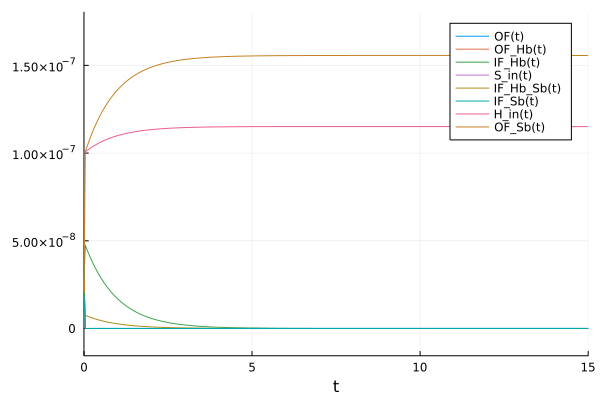

In [46]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Turing, Latexify, ModelingToolkit, DynamicHMC, Sundials
using ModelingToolkit: varmap_to_vars
using Optim
Random.seed!(14)

# load flux dataset fo ~ 300 data points
df = CSV.read("data_1c.csv", DataFrame) 
y_obs = df[!, "data"]

# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out         
end

# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r stdev_s
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
H_out_ref = 1e-7
S_out_ref = 1e-3

#pmap = [H_out => H_out_ref, S_out => S_out_ref,
#       k1_f =>10^8.2048, k1_r =>10^3.8047,
#       k2_f =>10^2.2232, k2_r =>10^-0.0276,
#       k3_f =>10^6.2126, k3_r =>10^4.0139,
#       k4_f =>10^0.3190, k4_r =>10^6.9358,
#       k5_f =>10^2.9380, k5_r =>10^-1.0432,
#       k6_f =>10^1.6900, k6_r =>10^k_tmp
#       ]

Random.seed!(9)

println(6*rand()+6)

k1_f_tmp = 10^8.2048 #10^(6*rand()+6) #10^8.2048 #1e10
k1_r_tmp = 10^3.8047 #10^(6*rand()-1) #10^3.8047 #1e3
k2_f_tmp = 10^2.2232 #10^(6*rand()-2) #10^2.2232 #1e2
k2_r_tmp = 10^-0.0276 #10^(6*rand()-2) #10^-0.0276 #1e2
k3_f_tmp = 10^6.2126 #10^(6*rand()+3) #10^6.2126 #1e7
k3_r_tmp = 10^4.0139 #10^(6*rand()-1) #10^4.0139 #1e3
k4_f_tmp = 10^0.3190 #10^(6*rand()-1) #10^0.3190 #1e3
k4_r_tmp = 10^6.9358 #10^(6*rand()+6) #10^6.9358 #1e10
k5_f_tmp = 10^2.9380 #10^(6*rand()-2) #10^2.9380 #1e2
k5_r_tmp = 10^-1.0432 #10^(6*rand()-2) #10^-1.0432 #1e2
k6_f_tmp = 10^1.6900 #10^(6*rand()-1) #10^1.6900 #1e3
k6_r_tmp = (k1_f_tmp*k2_f_tmp*k3_f_tmp*k4_f_tmp*k5_f_tmp*k6_f_tmp)/(k1_r_tmp*k2_r_tmp*k3_r_tmp*k4_r_tmp*k5_r_tmp)


pmap = [H_out => H_out_ref, S_out => S_out_ref,       
        k1_f =>k1_f_tmp, k1_r =>k1_r_tmp,
        k2_f =>k2_f_tmp, k2_r =>k2_r_tmp,        
        k3_f =>k3_f_tmp, k3_r =>k3_r_tmp,        
        k4_f =>k4_f_tmp, k4_r =>k4_r_tmp,
        k5_f =>k5_f_tmp, k5_r =>k5_r_tmp,
        k6_f =>k6_f_tmp, k6_r =>k6_r_tmp
       ]
       
df = DataFrame(
        "k1_f" =>k1_f_tmp, "k1_r" =>k1_r_tmp,
        "k2_f" =>k2_f_tmp, "k2_r" =>k2_r_tmp,        
        "k3_f" =>k3_f_tmp, "k3_r" =>k3_r_tmp,        
        "k4_f" =>k4_f_tmp, "k4_r" =>k4_r_tmp,
        "k5_f" =>k5_f_tmp, "k5_r" =>k5_r_tmp,
        "k6_f" =>k6_f_tmp, "k6_r" =>k6_r_tmp
)

println(df)
CSV.write("pmap_rand.csv", df)

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)
latexify(odesys)


# create ODEproblem w/ timed events discrete callback
tspan1 = (0.0,15.0)
oprob = ODEProblem(odesys, u0map, tspan1, pmap)
event_times = [5.0,10]
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 5.0
        integrator.p[1] = 5e-8
    elseif integrator.t == 10.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,affect!)

### testing
# calc flux (y_pred)
sol1 = solve(oprob, TRBDF2(), abstol = 1e-14, reltol = 1e-9, saveat=0.04, callback=cb, tstops=[5.0, 10.0])
k1 = [pmap[9][2], pmap[10][2]]
c1 = [sol1[IF_Hb_Sb], sol1[H_in], sol1[IF_Sb]]
vol1 = 0.0001
y_pred = calc_flux(k1,c1,vol1)
df = DataFrame(sol1)
CSV.write("data_pop_rand.csv", df)
### 

#sol_ss = solve(oprob,SSRootfind())
#println(sol_ss[end])
#println(sol1[1])
plot(sol1, ylim=[-1e-8,1.75e-7])
#plot(y_pred)

$\epsilon$

In [ ]:
𝜖
ϵ
 